In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.font_manager
import dash

In [35]:
df = pd.read_excel("data/20191116_Misstarget_Abuse_Pattern.xlsx")

In [36]:
df.shape

(13469, 32)

In [37]:
selected_cols = [
    "MonthReport",
    "PM_NAME",
    "PD_NAME",
    "Forecast_Cash_Flow_Display",
    "Actual_Cash_Flow_Display",
    "Tolerances_Name"
]

In [38]:
df.columns

Index(['DATA_TYPE', 'MonthReport', 'REF_UID', 'PROJECT_NAME', 'PM_ID',
       'PM_NAME', 'PD_ID', 'PD_NAME', 'BUDGET', 'Quarter',
       'Forecast_Cash_Flow', 'Actual_Cash_Flow', 'Forecast_Cash_Flow_Display',
       'Actual_Cash_Flow_Display', 'Variance_Display', 'Variance',
       'Percentage', 'Percentage_Display', 'Color', 'Tolerance_Level',
       'PC_Date', 'ClOSE_DATE', 'Tolerances_Name', 'Forecast_Cash_Flow_Total',
       'Forecast_Cash_Flow_Total_Display', 'Actual_Cash_Flow_Total',
       'Actual_Cash_Flow_Total_Display', 'Variance_Total',
       'Variance_Total_Display', 'Percentage_Average',
       'Percentage_Average_Display', 'TIMESTAMP'],
      dtype='object')

In [39]:
df = df[selected_cols]

In [40]:
df.head()

,MonthReport,PM_NAME,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name
0,2017-07,Michael Scott,Nicole Collin,0.0,5.46,Meet Target
1,2017-08,Michael Scott,Program Admin,0.0,44.19,Meet Target
2,2017-09,Michael Scott,Program Admin,0.0,17.02,Meet Target
3,2017-10,Michael Scott,Program Admin,0.0,3.59,Meet Target
4,2017-11,Michael Scott,Program Admin,0.0,4.13,Meet Target


In [41]:
df = df[df['Tolerances_Name']!='Not Applicable']
df = df[df['PD_NAME']!='Program Admin']
df = df[~((df['Forecast_Cash_Flow_Display']==0) & (df['Actual_Cash_Flow_Display']==0))]

In [42]:
# Exclude Project and Actual and Forecast are both 0
df[(df['Forecast_Cash_Flow_Display']==0) & (df['Actual_Cash_Flow_Display']==0)]

,MonthReport,PM_NAME,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name


In [43]:
df.shape

(6246, 6)

In [44]:
year_list = ['2016', '2017', '2018', '2019']
for year in year_list:
    print(f"{year}: {df[(df['MonthReport'].str.contains(year))].shape[0]}")

2016: 1799
2017: 1739
2018: 1512
2019: 1196


In [45]:
# Exclude 2016 and 2017
df = \
df[(df['MonthReport'].str.contains('2018')) \
   | (df['MonthReport'].str.contains('2019')) 
  ]

In [49]:
print(f"Total Project in [2018-2019]: {df.shape[0]}")

Total Project in [2018-2019]: 2708


In [14]:
df_analytics = df.copy()

In [15]:
# df_analytics['Forecast_Variation'] = df_analytics['Forecast_Cash_Flow_Display'] - df_analytics['Actual_Cash_Flow_Display']
# df_analytics['Forecast_Variation_Perc'] = df_analytics['Forecast_Variation'] / (df_analytics['Actual_Cash_Flow_Display'] + 0.001)
# df_analytics['Forecast_Variation_Perc'] = df_analytics['Forecast_Variation_Perc'].astype('float')
df_analytics['Forecast_Cash_Flow_Display'] = df_analytics['Forecast_Cash_Flow_Display'].astype('float')
df_analytics['Actual_Cash_Flow_Display'] =  df_analytics['Actual_Cash_Flow_Display'].astype('float')

In [16]:
df_analytics.head(10)

,MonthReport,PM_NAME,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name
0,2017-07,Michael Scott,Nicole Collin,0.00,5.46,Meet Target
19,2016-08,Mark Soderlund,Kevin Weatherall,921.74,173.18,Critical
20,2016-09,Mark Soderlund,Kevin Weatherall,460.99,432.22,Critical
21,2016-10,Mark Soderlund,Kevin Weatherall,981.38,1023.41,Meet Target
22,2016-11,Mark Soderlund,Kevin Weatherall,916.94,891.59,Near Target
23,2016-12,Mark Soderlund,Kevin Weatherall,4421.56,0.00,Critical
24,2017-01,Mark Soderlund,Kevin Weatherall,22.00,1.90,Critical
25,2017-02,Mark Soderlund,Kevin Weatherall,666.74,593.27,Critical
26,2017-03,Mark Soderlund,Kevin Weatherall,812.64,157.11,Critical
27,2017-04,Mark Soderlund,Kevin Weatherall,1106.76,1347.66,Meet Target


In [17]:
PM_name = 'Axel Keert'
df_angus = df_analytics[df_analytics['PM_NAME']==PM_name]
df_angus.head(10)

,MonthReport,PM_NAME,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name
6595,2019-04,Axel Keert,Axel Keert,0.0,63.15,Meet Target


In [18]:
df_0 = df[df['Forecast_Cash_Flow_Display']==0]
df_0.groupby(['PM_NAME']).count().sort_values('MonthReport',ascending=False)

,MonthReport,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name
PM_NAME,,,,,
Angus McGarvie,124,124,124,124,124
Jonathon Egan,88,88,88,88,88
Bradley Williamson,56,56,56,56,56
Dean Ristevski,44,44,44,44,44
Jeremy Chong,43,43,43,43,43
Aarron Cowen,33,33,33,33,33
Ron Too,25,25,25,25,25
Nick Ditterich,21,21,21,21,21
Arash Emami,20,20,20,20,20


In [19]:
PM_list = list(set(df_analytics['PM_NAME']))

In [20]:
pm_perf = dict()

for name in PM_list:
#     if name != 'Angus McGarvie':
#     if name != 'Aarron Cowen':
#     if name != 'Matthew Bartlett':
#         continue

    df_tmp = df_analytics[df_analytics['PM_NAME']==name]
    mse = mean_squared_error(df_tmp['Actual_Cash_Flow_Display'], df_tmp['Forecast_Cash_Flow_Display']) / sum(df_tmp['Actual_Cash_Flow_Display'])
    
    # Metric: Project Delivered
    project_num = df_tmp.shape[0]
    
    # Metric: Total Project Value Delivered
    project_value = df_tmp['Actual_Cash_Flow_Display'].sum()
    
    # Metric: Number of Time that Put Forecast as Zero
    zero_fcst = df_tmp[df_tmp['Forecast_Cash_Flow_Display']==0].shape[0]
    
    # Metric KS Distribution
    ks_distrb = ks_2samp(df_tmp['Forecast_Cash_Flow_Display'], df_tmp['Actual_Cash_Flow_Display'])
    
    # Metric: Total Number of Time that Missing Target
    underspend = df_tmp[(df_tmp['Forecast_Cash_Flow_Display'] - df_tmp['Actual_Cash_Flow_Display']) * 2 \
                        /(df_tmp['Actual_Cash_Flow_Display'] - df_tmp['Forecast_Cash_Flow_Display'])>0.05].shape[0]
                        
    overderspend = df_tmp[(df_tmp['Actual_Cash_Flow_Display'] - df_tmp['Forecast_Cash_Flow_Display']) * 2 \
                        /(df_tmp['Actual_Cash_Flow_Display'] - df_tmp['Forecast_Cash_Flow_Display'])>0.05].shape[0]
    
    miss_target_project_num = underspend + overderspend

    # Metric: Percentage of Miss-target Project
    miss_target_project_ratio = miss_target_project_num / project_num

    
    # Metric: MAPE
    df_tmp.loc[:,'miss_taget_value_monthly_mape'] = abs(df_tmp['Forecast_Cash_Flow_Display'] - df_tmp['Actual_Cash_Flow_Display']) * 2 /\
                                           (df_tmp['Forecast_Cash_Flow_Display'] + df_tmp['Actual_Cash_Flow_Display'])
    
    miss_taget_value_monthly_mape = df_tmp['miss_taget_value_monthly_mape'].mean()
    
    # Metric: Total Missing Target $ Value (Can Cancel Off)
    miss_target_value = sum(df_tmp['Forecast_Cash_Flow_Display']) - sum(df_tmp['Actual_Cash_Flow_Display'])
    
    # Metric: Total Missing Target $ Value Percentage (Can Cancel Off)    
    miss_target_value_perc_error = (sum(df_tmp['Forecast_Cash_Flow_Display']) - sum(df_tmp['Actual_Cash_Flow_Display'])) * 2 / \
                                   (sum(df_tmp['Forecast_Cash_Flow_Display']) + sum(df_tmp['Actual_Cash_Flow_Display']))

    # Metric: Total Logged Missing Target Absolute $ Value (Can't Cancel Off)    
    miss_target_value_log_error = np.log(sum(abs((df_tmp['Forecast_Cash_Flow_Display']) - (df_tmp['Actual_Cash_Flow_Display']))))
    
    pm_perf[name] = [
        project_num,
        project_value,
        zero_fcst,
#         ks_distrb,
        miss_taget_value_monthly_mape,
        miss_target_project_num,
        miss_target_project_ratio,
        miss_target_value,
        miss_target_value_perc_error,
        miss_target_value_log_error
    ]

In [21]:
df_pm_perf = pd.DataFrame.from_dict(pm_perf, orient='index',
                                 columns=['project_num',
                                          'project_value',
                                          'zero_fcst',
#                                           'ks_distrb',
                                          'miss_taget_value_monthly_mape',
                                          'miss_target_project_num',
                                          'miss_target_project_ratio',
                                          'miss_target_value',
                                          'miss_target_value_perc_error',
                                          'miss_target_value_log_error'
                                         ])

In [23]:
# Only track PMs who have delivered >10 project and total project value > $50K
df_pm_perf = df_pm_perf[(df_pm_perf['project_num']>=10) | (df_pm_perf['project_value']>=50)]

In [24]:
df_pm_perf.sort_values('miss_taget_value_monthly_mape').tail(3)

,project_num,project_value,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_num,miss_target_project_ratio,miss_target_value,miss_target_value_perc_error,miss_target_value_log_error
Program Close,8,333.23,8,2.000000,8,1.000000,-333.23,-2.000000,5.808833
Axel Keert,1,63.15,1,2.000000,1,1.000000,-63.15,-2.000000,4.145513
Stephen Lindsay,26,6546.16,0,19.803276,23,0.884615,400.93,0.059427,7.709501


In [25]:
df_pm_perf[(df_pm_perf.index=='Angus McGarvie') | (df_pm_perf.index=='Aarron Cowen') | (df_pm_perf.index=='Eric Sun')]

,project_num,project_value,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_num,miss_target_project_ratio,miss_target_value,miss_target_value_perc_error,miss_target_value_log_error
Eric Sun,125,195897.41,9,0.736999,118,0.944000,48182.61,0.219023,11.250029
Angus McGarvie,298,28361.94,124,1.441785,281,0.942953,-11180.51,-0.490983,9.990331
Aarron Cowen,359,15062.46,33,1.331137,344,0.958217,8761.25,0.450610,9.704602


In [26]:
col_list = [
    'zero_fcst',
    'miss_taget_value_monthly_mape',  
    'miss_target_project_ratio',
    'miss_target_value',
    'miss_target_value_log_error'
]

df_pm_perf_select = df_pm_perf[col_list].dropna()

In [27]:
df_pm_perf_select.head(3)

,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value,miss_target_value_log_error
Chris Webster,0,0.770221,1.000000,976.03,7.772016
Rob Bacon,16,1.294339,0.936364,3310.80,8.623958
Tish Booth,4,1.508638,0.950000,8654.13,9.073245


In [28]:
for col in col_list:
    df_pm_perf_select[col] = df_pm_perf_select[col] / df_pm_perf_select[col].max()

In [29]:
df_pm_perf_select[(df_pm_perf_select.index=='Angus McGarvie') | (df_pm_perf_select.index=='Aarron Cowen') | (df_pm_perf_select.index=='Eric Sun') | (df_pm_perf_select.index=='Alexis Kouts')]

,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value,miss_target_value_log_error
Eric Sun,0.072581,0.037216,0.944000,1.000000,1.000000
Angus McGarvie,1.000000,0.072805,0.942953,-0.232045,0.888027
Alexis Kouts,0.153226,0.050915,0.968037,0.197356,0.847586
Aarron Cowen,0.266129,0.067218,0.958217,0.181834,0.862629


In [30]:
data = df_pm_perf_select[col_list].as_matrix()

In [31]:
top_n_outlier = 20
num_PM = len(PM_list)
outliers_fraction = top_n_outlier * 1.0 / num_PM

In [36]:
select_metrics= [
    'miss_taget_value_monthly_mape',
    'miss_taget_value_monthly_mape',
    'miss_taget_value_monthly_mape',
    'miss_target_project_ratio', 
    'miss_target_value',
    'miss_target_value_log_error'
]

In [37]:
df_pm_perf_select['pm_performance_score[abs]'] = 1 - df_pm_perf_select.apply(lambda x: np.linalg.norm(x[select_metrics]), axis=1)/np.sqrt(len(select_metrics))

In [38]:
print(f"Median Score: {df_pm_perf_select['pm_performance_score[abs]'].median():.02f}")

Median Score: 0.51


In [40]:
df_pm_perf_select.sort_values('pm_performance_score[abs]', ascending=False).tail(20)

,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value,miss_target_value_log_error,pm_performance_score[abs]
Cindy Deayton,0.040323,0.056786,0.982456,0.047937,0.785854,0.484449
Adel Mousa,0.080645,0.056187,0.954545,0.012646,0.824234,0.483578
Richard Feltscheer,0.000000,0.079358,1.000000,0.066805,0.759988,0.483451
Tish Booth,0.032258,0.076181,0.950000,0.179611,0.806509,0.483178
Chris Thrasis,0.048387,0.070667,0.982609,0.114018,0.780860,0.483079
Nick Ditterich,0.169355,0.055971,0.973684,-0.018380,0.808444,0.481769
Julian Smith,0.016129,0.065102,1.000000,0.084906,0.787653,0.477136
Matthew Behn,0.064516,0.068398,0.981481,0.167797,0.814437,0.472616
Jack Izowski,0.145161,0.056689,0.980645,0.008468,0.839724,0.471399
Alexis Kouts,0.153226,0.050915,0.968037,0.197356,0.847586,0.467362


In [41]:
df_pm_perf_select[(df_pm_perf_select.index=='Angus McGarvie') | (df_pm_perf_select.index=='Aarron Cowen') | (df_pm_perf_select.index=='Eric Sun')]

,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value,miss_target_value_log_error,pm_performance_score[abs]
Eric Sun,0.072581,0.037216,0.944000,1.000000,1.000000,0.305343
Angus McGarvie,1.000000,0.072805,0.942953,-0.232045,0.888027,0.460324
Aarron Cowen,0.266129,0.067218,0.958217,0.181834,0.862629,0.466313


In [42]:
classifiers = {
#         'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
#         'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=42),
#         'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=42),
#         'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
#         'Isolation Forest': IForest(contamination=outliers_fraction,random_state=42),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
#         'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

In [43]:
col_list = ['pm_performance_score[abs]', 'zero_fcst']

for col in col_list:
    df_pm_perf_select[col] = df_pm_perf_select[col] / df_pm_perf_select[col].max()

In [45]:
top_n_outlier = 5

X_train = df_pm_perf_select[col_list].as_matrix()

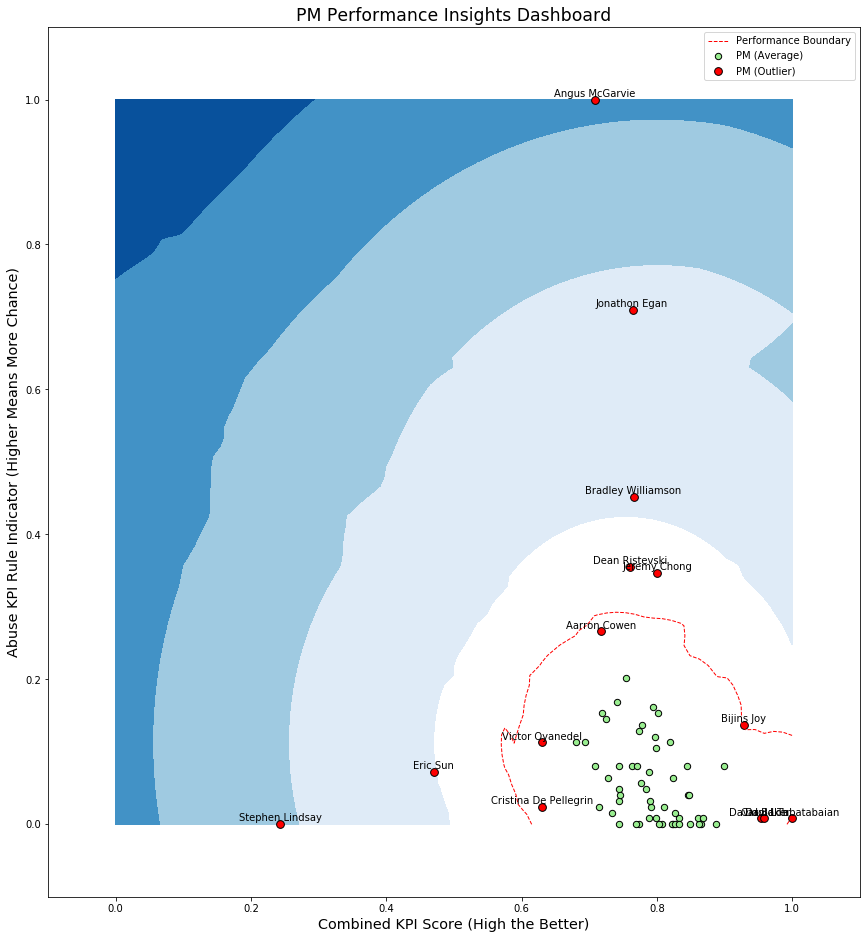

In [47]:
#set the figure size

fig = plt.figure(figsize=(32, 16))

xx , yy = np.meshgrid(np.linspace(0, 1, num_PM), np.linspace(0, 1, num_PM))

for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X_train)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train)
    y_pred_proba = clf.predict_proba(X_train)
    threshold = np.percentile(y_pred_proba[:,0], 20)
    y_pred = np.where(y_pred_proba[:,0]>threshold, 0, 1)
    
    df_pm_perf_select['outlier'] = y_pred

    # rest of the code is to create the visualization

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred, top_n_outlier)

#     # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, 2, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold+0.02, 5),cmap=plt.cm.Blues_r)

#     # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold+0.12],linewidths=1, colors='red')

#     # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
#     subplot.contourf(xx, yy, Z, levels=[threshold+0.02, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
#     b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 

    df_pm_perf_select_ok = df_pm_perf_select[df_pm_perf_select['outlier']==0]
    df_pm_perf_select_under = df_pm_perf_select[df_pm_perf_select['outlier']==1]

    inlier = subplot.scatter(df_pm_perf_select_ok[col_list[0]], df_pm_perf_select_ok[col_list[1]], c='#99EE90',s=40, edgecolor='k') 
    outlier = subplot.scatter(df_pm_perf_select_under[col_list[0]], df_pm_perf_select_under[col_list[1]], c='red',s=60, edgecolor='k')
    subplot.axis('tight')

    subplot.legend(
#         [a.collections[0], b, c],
#         ['learned decision function', 'true inliers', 'true outliers'],
        [a.collections[0], inlier, outlier],
        ['Performance Boundary', 'PM (Average)', 'PM (Outlier)'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='higher right')

    subplot.set_title("PM Performance Insights Dashboard", fontsize='xx-large')
    x_axis_max = df_pm_perf_select[col_list[0]].max()*1.1
    x_axis_min = min(df_pm_perf_select[col_list[0]].min()*1.1, -0.1)
    y_axis_max = df_pm_perf_select[col_list[1]].max()*1.1
    y_axis_min = min(df_pm_perf_select[col_list[1]].min()*1.1, -0.1)
    
    subplot.set_xlim((x_axis_min, x_axis_max))
    subplot.set_ylim((y_axis_min, y_axis_max))
    subplot.set_xlabel("Combined KPI Score (High the Better)", fontsize='x-large')
    subplot.set_ylabel("Abuse KPI Rule Indicator (Higher Means More Chance)", fontsize='x-large')
    
    for index, row in df_pm_perf_select.iterrows():

        label = index
        x = row[col_list[0]]
        y = row[col_list[1]]
        
        if row['outlier']==0:
            continue
            
#         if label != 'Angus McGarvie':
#             continue
            
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,3), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.savefig('./output/pm_performance_dashboard.pdf')
    plt.show()

In [52]:
df_pm_perf_select[df_pm_perf_select['outlier']==1]

,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value,miss_target_value_log_error,pm_performance_score[abs],outlier
Eric Sun,0.072581,0.037216,0.944000,1.000000,1.000000,0.469987,1
David Baker,0.008065,0.058160,0.800000,0.002415,0.464035,0.954621,1
David Tabatabaian,0.008065,0.030413,0.800000,0.000191,0.305871,1.000000,1
Bradley Williamson,0.451613,0.080530,1.000000,-0.021249,0.704034,0.765622,1
Carol Loh,0.008065,0.069679,0.833333,0.000810,0.380836,0.958496,1
Angus McGarvie,1.000000,0.072805,0.942953,-0.232045,0.888027,0.708537,1
Cristina De Pellegrin,0.024194,0.046204,0.974359,0.486452,0.949769,0.629800,1
Jonathon Egan,0.709677,0.066953,0.920923,0.044092,0.809580,0.764770,1
Stephen Lindsay,0.000000,1.000000,0.884615,0.008321,0.685287,0.243432,1
Dean Ristevski,0.354839,0.059067,0.923977,-0.059814,0.818567,0.759962,1


In [48]:
df_pm_perf_select[['zero_fcst', 'pm_performance_score[abs]', 'outlier']].reset_index().rename(columns={'index':'pm'}).to_csv('./data/pm_perf.csv', index=False)

In [50]:
pd.read_csv('data/pm_perf.csv').head(3)

,pm,zero_fcst,pm_performance_score[abs],outlier
0,Chris Webster,0.000000,0.774182,0
1,Rob Bacon,0.129032,0.774251,0
2,Tish Booth,0.032258,0.743714,0


In [ ]:
# df_angus['Forecast_Cash_Flow_Display'].plot(figsize=(24,16))
# df_angus['Actual_Cash_Flow_Display'].plot(figsize=(24,16))

In [ ]:
# agg_cond = [
#     'PM_NAME',
# ]
# target = ['Forecast_Variation_Perc']
# selected_cols = agg_cond + target
# agg_ops = [
#     'mean'
# ]
# agg_target = target[0] + '_' + agg_ops[0]
# df_agg = df_analytics[selected_cols].groupby(agg_cond).agg(agg_ops)

# df_agg.columns = ['_'.join(col).strip(' ') for col in df_agg.columns.values]
# df_agg = df_agg.reset_index()

# df_agg.sort_values(agg_target, ascending=False)

In [53]:
import plotly.offline as pyo
import plotly.graph_objs as go

In [54]:
np.random.seed(42)
random_x = np.random.randint(1,101,100)
random_y = np.random.randint(1,101,100)

df = pd.read_csv('data/pm_perf.csv')

data = [go.Scatter(x=df[df['outlier']==0]['pm_performance_score[abs]'],
                   y=df[df['outlier']==0]['zero_fcst'],
                   text = df[df['outlier']==0]['pm'],
                   mode='markers',
                   name = "PM (Average)",
                   marker=dict(
                     size=8,
                     color='rgb(51,204,153)',
                     symbol='circle',
                     line={'width':2}
                   ))]

data = \
data + ([go.Scatter(x=df[df['outlier']==1]['pm_performance_score[abs]'],
                   y=df[df['outlier']==1]['zero_fcst'],
                   text = df[df['outlier']==1]['pm'],
                   mode='markers',
                   name = "PM (Outlier)",
                   marker=dict(
                     size=8,
                     color='red',
                     symbol='circle',
                     line={'width':2}
                   ))])


layout = go.Layout(title='PM Performance Insights Dashboard',
                   xaxis=dict(title='Combined KPI Score (High the Better)'),
                   yaxis=dict(title='Abuse KPI Rule Indicator (Higher Means More Chance)'),
                   hovermode='closest')

fig = go.Figure(data=data,layout=layout)

pyo.plot(fig, filename='pr_perf_dashboard_interactive.html')

'pr_perf_dashboard_interactive.html'